In [44]:
%load_ext autoreload


%autoreload 2
import matplotlib.pyplot as plt
import pickle
import emcee
import sys
import numpy as np
import corner
from astropy.table import Table

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_DATAOPS_make_profile as prf
import analysis_Mass_Richness_relation as analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

# Load data

In [46]:
ind_profile = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/data_new_version/ind_profile_redmapper.pkl', allow_pickle = True)
ind_profile['cluster_id'] = ind_profile['id']

In [47]:
sum_weights_per_cluster_true_10 = []
sum_weights_per_cluster_true_5 = []
for i, cl in enumerate(ind_profile):
    mask = (ind_profile['radius_true'][i] > 1)*(ind_profile['radius_true'][i] < 10)
    sum_weights_per_cluster_true_10.append(np.sum(ind_profile['W_l_true'][i][mask]))
    mask = (ind_profile['radius_true'][i] > 1)*(ind_profile['radius_true'][i] < 5.5)
    sum_weights_per_cluster_true_5.append(np.sum(ind_profile['W_l_true'][i][mask]))

In [48]:
ind_profile['weight_per_cluster_true_5'] = np.array(sum_weights_per_cluster_true_5)*1e27
ind_profile['weight_per_cluster_true_10'] = np.array(sum_weights_per_cluster_true_10)*1e27

In [49]:
sum_weights_per_cluster_bpz_10 = []
sum_weights_per_cluster_bpz_5 = []
for i, cl in enumerate(ind_profile):
    mask = (ind_profile['radius_bpz'][i] > 1)*(ind_profile['radius_bpz'][i] < 10)
    sum_weights_per_cluster_bpz_10.append(np.sum(ind_profile['W_l_bpz'][i][mask]))
    mask = (ind_profile['radius_bpz'][i] > 1)*(ind_profile['radius_bpz'][i] < 5.5)
    sum_weights_per_cluster_bpz_5.append(np.sum(ind_profile['W_l_bpz'][i][mask]))

In [50]:
ind_profile['weight_per_cluster_bpz_5'] = np.array(sum_weights_per_cluster_bpz_5)*1e27
ind_profile['weight_per_cluster_bpz_10'] = np.array(sum_weights_per_cluster_bpz_10)*1e27

In [51]:
sum_weights_per_cluster_flex_10 = []
sum_weights_per_cluster_flex_5 = []
for i, cl in enumerate(ind_profile):
    mask = (ind_profile['radius_flex'][i] > 1)*(ind_profile['radius_flex'][i] < 10)
    sum_weights_per_cluster_flex_10.append(np.sum(ind_profile['W_l_flex'][i][mask]))
    mask = (ind_profile['radius_flex'][i] > 1)*(ind_profile['radius_flex'][i] < 5.5)
    sum_weights_per_cluster_flex_5.append(np.sum(ind_profile['W_l_flex'][i][mask]))

In [52]:
ind_profile['weight_per_cluster_flex_5'] = np.array(sum_weights_per_cluster_flex_5)*1e27
ind_profile['weight_per_cluster_flex_10'] = np.array(sum_weights_per_cluster_flex_10)*1e27

In [70]:
ind_profile

id,ra,dec,redshift,richness,DSt_true,DSx_true,W_l_true,radius_true,DSt_flex,DSx_flex,W_l_flex,radius_flex,DSt_bpz,DSx_bpz,W_l_bpz,radius_bpz,cluster_id,weight_per_cluster_true_5,weight_per_cluster_true_10,weight_per_cluster_bpz_5,weight_per_cluster_bpz_10,weight_per_cluster_flex_5,weight_per_cluster_flex_10
int64,float64,float64,float32,float32,float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],float64[15],int64,float64,float64,float64,float64,float64,float64
4835,60.1207701187705,-35.74737806182082,0.8966372,21.559492,181970202039987.4 .. -28443127135230.145,-121039939628388.1 .. -21985931615491.89,1.4180508196511585e-30 .. 2.0250401348304404e-28,0.5527313667973088 .. 9.109776808324828,186844158302200.06 .. -28130753176707.68,-94406510728502.52 .. -23161785687557.227,1.2809401389525147e-30 .. 2.00502872517232e-28,0.5526983369189398 .. 9.107341532359275,229408661422969.3 .. -30475882564310.934,-108653582159705.6 .. -23529352904882.918,1.1542652404066941e-30 .. 1.8563679470487896e-28,0.5570769071349138 .. 9.105309294464476,4835,0.16903709046398135,0.5877441350664222,0.1472356022633458,0.5225976213967364,0.1679053914315133,0.5834192504661593
469,50.8966866200705,-44.45493260669247,0.62144566,67.09559,101473623143260.23 .. -10043112864669.078,-35887467578322.05 .. -1437950060441.7378,3.0116534980031034e-30 .. 8.233913568744426e-28,0.5517712415705935 .. 9.121209309502692,107897703822353.47 .. -10165490715356.232,-41169782555698.96 .. -1353983749805.2114,2.9963764470191383e-30 .. 8.248629622102231e-28,0.552239228793423 .. 9.120522698056662,100454892424314.47 .. -11818278402811.826,-35638929602281.72 .. -1889540588074.1912,2.8685370633676007e-30 .. 7.7917764479001615e-28,0.551797720465266 .. 9.125507961269342,469,0.6640101937352697,2.3612189445692215,0.6315828858586464,2.245355024960733,0.668513491840032,2.3719263128676324
7043,72.99011209131204,-40.587925971785054,0.889254,20.217054,97881380813686.16 .. 3887784045769.054,8072260980519.0 .. 1044440307522.794,9.633161809747258e-31 .. 1.9732417114529207e-28,0.5736735982046974 .. 9.14595416598728,93953737194012.14 .. 4145301969984.8984,7039094084410.3125 .. 1641104810481.4553,9.543965840067045e-31 .. 1.954503218913488e-28,0.5728915484293453 .. 9.144104324927497,126276479793492.92 .. 9473736202452.504,-41687767791710.445 .. 6800227385406.311,7.040289281137459e-31 .. 1.8237833212338301e-28,0.5742616367375348 .. 9.15928227130137,7043,0.17623832288543867,0.5767030052544213,0.15800059542506617,0.5299753892990338,0.17401886229543095,0.5686678696134753
3356,49.211119675755015,-31.117136628863747,0.60960704,26.258024,-10376143498329.596 .. -2325086854171.113,159996224784037.97 .. -2612206554365.4937,2.8203970915992385e-30 .. 6.505801834573477e-28,0.5539945696756196 .. 9.127824858851557,-5422831698024.002 .. -1965062340104.346,157798891268474.9 .. -2005404590317.263,2.8592699160753785e-30 .. 6.551576855809062e-28,0.5536524789085484 .. 9.126757912192435,13841718145833.443 .. -2693003317705.131,174246427292332.88 .. -724987637473.043,2.768877373940194e-30 .. 6.361042717974786e-28,0.5569526443568353 .. 9.125734944364337,3356,0.7491798461355804,2.0932092607817694,0.7150365120779707,2.0327867947105767,0.7527720502483205,2.106572435915462
4405,57.00381256004044,-31.200967027470817,0.41625932,21.879847,239179990463104.6 .. -1260336771650.6157,28313931125033.656 .. 430047622508.0653,1.1700788547153446e-29 .. 2.1093841410489106e-27,0.5525299141278757 .. 9.121906300526922,240719445093826.3 .. -1249963123100.8247,27727088470384.67 .. 366839947505.8924,1.1681332259714397e-29 .. 2.1108101095421127e-27,0.5522587683943728 .. 9.121500003910127,245870593739057.78 .. -2299263070897.441,15145051713930.822 .. 245773558391.89246,1.1106164621357106e-29 .. 2.0443073241787993e-27,0.5533498436412896 .. 9.12224726579502,4405,1.870597778347071,6.301148580810867,1.8190470661968388,6.10848807537671,1.8709499240958023,6.302381712934712
4343,58.

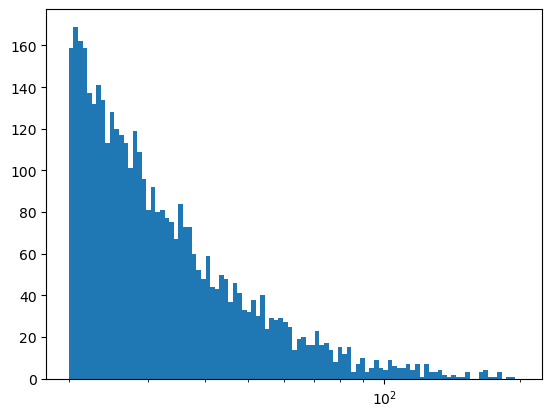

In [53]:
plt.hist(ind_profile['richness'], bins=np.logspace(np.log10(20), np.log10(200), 100))
plt.xscale('log')

In [54]:
np.quantile(ind_profile['richness'][ind_profile['richness'] < 120], [0, .25, .5, .75, 1])

20.00348472595215
23.451108932495117
28.72933006286621
39.407814025878906
119.55744934082031


In [55]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

In [56]:
Obs_bin

[[20, 35], [35, 70], [70, 100], [100, 200]]

In [57]:
Z_bin

[[0.2, 0.3],
 [0.3, 0.4],
 [0.4, 0.5],
 [0.5, 0.6],
 [0.6, 0.7],
 [0.7, 0.8],
 [0.8, 1.0]]

# WL mass

## Estimating shear profile

In [94]:
profile_true_stack = prf.stacked_profile(profile = ind_profile,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin, add_columns_to_bin = ['W_l_true','richness', 'redshift', 
                                                                            'weight_per_cluster_true_5', 'weight_per_cluster_true_10',
                                                                            'weight_per_cluster_bpz_5', 'weight_per_cluster_bpz_10',
                                                                            'weight_per_cluster_flex_5', 'weight_per_cluster_flex_10'])
covariance_true_stack = prf.bootstrap_covariance(profile = ind_profile,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    #n_jack = 50,
                                                #ra = 'ra', dec = 'dec',
                                                n_boot = 600,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

140
73
14
6
252
104
13
6
300
137
17
17
354
122
19
12
367
153
31
14
304
139
21
7
650
288
32
22


In [95]:
t = {'stacked profile':profile_true_stack, 'stacked covariance': covariance_true_stack}

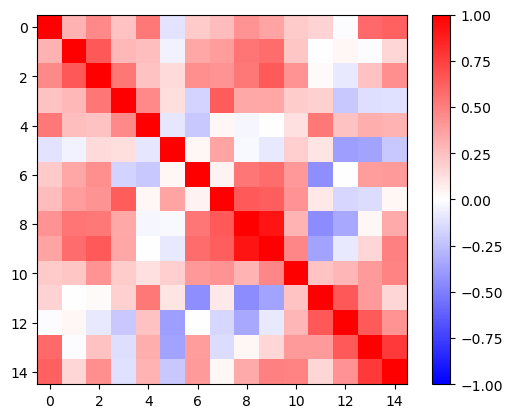

In [99]:
cov = t['stacked covariance']
cov_t = cov['cov_t'][15]
corr = np.zeros(cov_t.shape)
for i in range(corr.shape[0]):
    for j in range(corr.shape[0]):
        corr[i,j] = cov_t[i,j]/np.sqrt(cov_t[i,i]*cov_t[j,j])
plt.imshow(corr, vmin=-1, vmax = 1, cmap='bwr')
plt.colorbar()

In [40]:
#save_pickle(t, '/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_true.pkl', allow_pickle=True)

In [13]:
profile_BPZ_stack = prf.stacked_profile(profile = ind_profile,
 r_in = 'radius_bpz',
                    gt_in = 'DSt_bpz', gx_in = 'DSx_bpz',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_bpz',
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin, add_columns_to_bin = ['W_l_bpz','richness', 'redshift'])
covariance_BPZ_stack = prf.bootstrap_covariance(profile = ind_profile,
                    r_in = 'radius_bpz',
                    gt_in = 'DSt_bpz', gx_in = 'DSx_bpz',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_bpz',
                    n_boot = 400,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

140
73
14
6
252
104
13
6
300
137
17
17
354
122
19
12
367
153
31
14
304
139
21
7
650
288
32
22


In [14]:
t2 = {'stacked profile':profile_BPZ_stack, 'stacked covariance': covariance_BPZ_stack}

In [15]:
len(profile_BPZ_stack)

28

In [16]:
save_pickle(t2, '/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_BPZ.pkl', allow_pickle=True)

In [17]:
profile_flex_stack = prf.stacked_profile(profile = ind_profile,
 r_in = 'radius_flex',
                    gt_in = 'DSt_flex', gx_in = 'DSx_flex',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_flex',
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin, add_columns_to_bin = ['W_l_flex','richness', 'redshift'])

covariance_flex_stack = prf.bootstrap_covariance(profile = ind_profile,
                    r_in = 'radius_flex',
                    gt_in = 'DSt_flex', gx_in = 'DSx_flex',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_flex',
                    n_boot = 400,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

140
73
14
6
252
104
13
6
300
137
17
17
354
122
19
12
367
153
31
14
304
139
21
7
650
288
32
22


In [18]:
t3 = {'stacked profile':profile_flex_stack, 'stacked covariance': covariance_flex_stack}

In [19]:
len(profile_flex_stack)

28

In [20]:
save_pickle(t3, '/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_flex.pkl', allow_pickle=True)